# Fit a GAP Potential
Explore how we can fit a [GAP](https://arxiv.org/pdf/1502.01366.pdf) potential using [MAML](https://github.com/materialsvirtuallab/maml) and [QUIP](https://libatoms.github.io/GAP/index.html)

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from mcdemo.lfa.gap.quippy import fit_gap
from sklearn.model_selection import train_test_split
from functools import partial
from tqdm import tqdm
from ase import Atoms
import pandas as pd
import numpy as np
import json
import os

## Load in the Dataset
Get the dataset form the previous example

In [2]:
data = pd.read_pickle('atoms.pkl.gz')
print(f'Loaded {len(data)} training examples')

Loaded 256 training examples


Make a train-test split

In [3]:
train_data, test_data = train_test_split(data, train_size=0.9, shuffle=True)

## Test Model with Some Default Parameters
Use a 90/10 train/test split

In [4]:
%%time
p = fit_gap(train_data['atoms'], train_data['energy'], None, cutoff=6, n_sparse=256, n_max=8, l_max=8, use_forces=False)

CPU times: user 19.8 s, sys: 277 ms, total: 20.1 s
Wall time: 36 s


In [5]:
%%time
pred_y = test_data['atoms'].apply(p.get_potential_energy)
print(f'MAE: {(pred_y - test_data["energy"]).abs().mean()} Ha')

MAE: 0.007964233263158768 Ha
CPU times: user 941 ms, sys: 16 ms, total: 957 ms
Wall time: 955 ms


Text(0, 0.5, '$\\Delta E$, ML (Ha)')

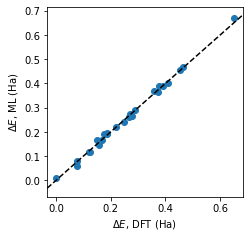

In [6]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['energy'] - test_data['energy'].min(), pred_y - test_data['energy'].min())

lims = ax.get_xlim()
ax.set_xlim(lims)
#ax.set_ylim(lims)
ax.plot(lims, lims, 'k--')

ax.set_xlabel('$\Delta E$, DFT (Ha)')
ax.set_ylabel('$\Delta E$, ML (Ha)')

## Optimize the Hyperparmeters
We have a few key parameters to fit, including the complexity of the SOAP intergrals (defined by $n_{max}$ and $l_{max}$) and the GAP model (defined by the number of points)

In [7]:
subtrain_data, val_data = train_test_split(train_data, test_size=0.1)

In [8]:
n_max = [2, 4, 6, 8]
l_max = [2, 4, 6, 8]

In [9]:
n_grid, l_grid = np.meshgrid(n_max, l_max)
n_grid = n_grid.flatten()
l_grid = l_grid.flatten()

In [10]:
grid_mae = []
for n, l in tqdm(zip(n_grid.flatten(), l_grid.flatten())):
    p = fit_gap(subtrain_data['atoms'], subtrain_data['energy'], subtrain_data['forces'].values,
                n_sparse=256, n_max=n, l_max=l, cutoff=6)
    pred_y = val_data['atoms'].apply(p.get_potential_energy)
    grid_mae.append(np.abs(pred_y - val_data['energy']).mean())

16it [07:24, 27.78s/it]


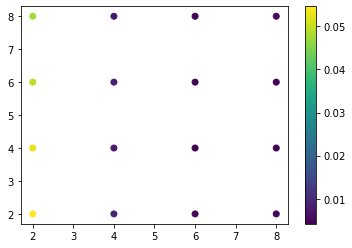

In [11]:
fig, ax = plt.subplots()

l = ax.scatter(n_grid, l_grid, c=grid_mae)

fig.colorbar(l)

Just cranking the $n$ and $l$ seems to do the trick

## Make a Learning Curve
Plot the accuracy as a function of number of training set entries

In [12]:
results = []
for ts in tqdm([2, 8, 32, 128]):
    subset = train_data.sample(ts)
    
    # Fit
    p = fit_gap(subset['atoms'], subset['energy'], subset['forces'].values, cutoff=6, n_sparse=256, n_max=8, l_max=8)
    
    #
    pred_y = test_data['atoms'].apply(p.get_potential_energy)
    mae = (pred_y - test_data["energy"]).abs().mean()
    
    results.append({
        'train_size': ts,
        'mae': mae,
    })

100%|██████████| 4/4 [01:19<00:00, 19.84s/it]


Plot the performance

In [13]:
results = pd.DataFrame(results)

Text(0, 0.5, 'MAE (Ha)')

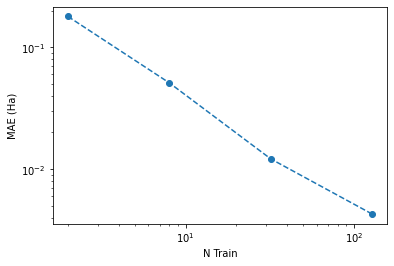

In [14]:
fig, ax = plt.subplots()

ax.loglog(results['train_size'], results['mae'], '--o')

ax.set_xlabel('N Train')
ax.set_ylabel('MAE (Ha)')